Model

$$y = \alpha(x) + \beta(x) z + u$$
$$u \sim N(0,1)$$
$$\alpha(x) = 0.2 x_1 -0.3 x_2 -0.5 x_3$$
$$\beta(x) = 2 - x_2 -0.25 x_1^3$$



Data

In [ ]:
import torch as to
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123423)
to.manual_seed(123423)
n = 10000
d_x = 5
d_param = 2
d_z = 1
device = ("cuda" if to.cuda.is_available() else "cpu")
print(f"Using {device} device")
x = to.randn((n, d_x)).to(device)
b = (2 - x[:, 1] - 0.25 * x[:, 0] ** 3).to(device)
a = (0.2 * x[:, 0] - 0.3 * x[:, 1] - 0.5 * x[:, 2]).to(device)
z = (0+1*to.randn(n, ) > 0).type(to.float32).to(device)
u = (to.randn((n,))).to(device)
y = (a + b * z + u).to(device)
print(y.shape, x.shape, z.shape, a.shape, b.shape)

Using cuda device
torch.Size([10000]) torch.Size([10000, 5]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000])


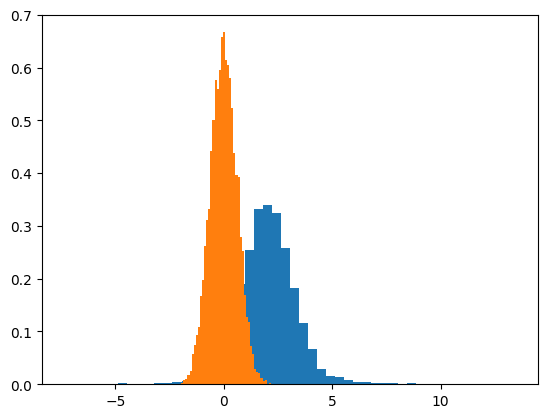

In [ ]:
plt.hist(b.cpu().detach().numpy(), bins = 50, density = True)
plt.hist(a.cpu().detach().numpy(), bins = 50, density = True)
plt.show()

Deep Net

In [ ]:
from torch import nn
arch = [20, 20]

class NeuralNetwork(nn.Module):
    def __init__(self, d_x, arch, d_param):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(d_x, arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], arch[1]),
            nn.ReLU(),
            nn.Linear(arch[1], d_param)
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(d_x, arch, d_param).to(device)
print(model)
print(model(x))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)
tensor([[ 0.2718,  0.2659],
        [ 0.1477,  0.1694],
        [ 0.2962,  0.0996],
        ...,
        [ 0.2009,  0.1313],
        [ 0.4508,  0.1681],
        [-0.1095,  0.4340]], device='cuda:0', grad_fn=<AddmmBackward0>)


Train

In [ ]:
# Train
m = 1000
optimizer = to.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.MSELoss(reduction='mean')

for t in range(m):
    # predict
    params = model(x)
    alpha = params[:,0].reshape(n,)
    beta = params[:,1].reshape(n,)

    # gradients
    #params.retain_grad()
    #alpha.retain_grad()
    #beta.retain_grad()
    y_hat = alpha + beta * z

    # loss
    loss = loss_fn(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % (m/10) == 0:
        print(loss.item())

3.940417766571045
1.0453466176986694
0.9815317392349243
0.9738574028015137
0.9700611233711243
0.9675761461257935
0.9655130505561829
0.9647130370140076
0.9611530900001526
0.9601392149925232


Estimated Params

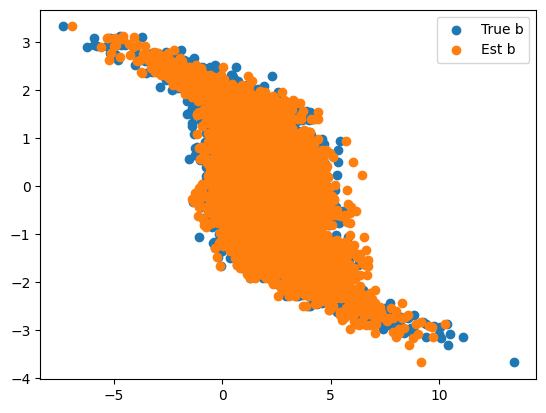

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(b.cpu().detach().numpy(), x[:,0].cpu().detach().numpy(), label = 'True b')
plt.scatter(beta.cpu().detach().numpy(), x[:,0].cpu().detach().numpy(), label = 'Est b')
plt.legend()
plt.show()

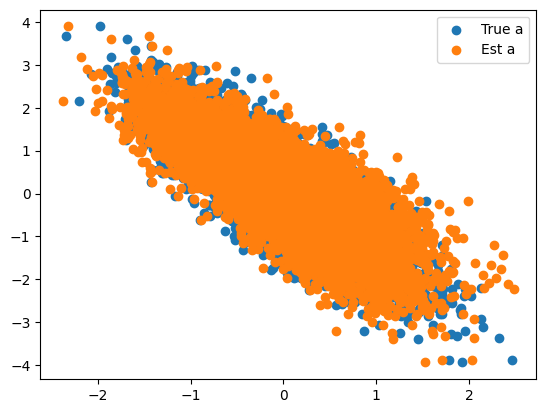

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(a.cpu().detach().numpy(), x[:,2].cpu().detach().numpy(), label = 'True a')
plt.scatter(alpha.cpu().detach().numpy(), x[:,2].cpu().detach().numpy(), label = 'Est a')
plt.legend()
plt.show()

In [ ]:
print(np.mean(b.cpu().detach().numpy()))
print(np.mean(beta.cpu().detach().numpy()))

2.0224352
2.039438


Doubly Robust Inference

In [ ]:
Z = z.clone()
Y = y.clone()
Y_hat = y_hat.clone()
mu0 = alpha.clone()
mu1 = beta.clone()
e = to.mean(Z)
IF = (mu1 + Z * (Y-mu1)/e) - (mu0+(1-Z)*(Y-mu0)/(1-e))
DR_est = to.mean(IF)
DR_se = to.sqrt(to.var(IF)/n)
print(DR_est.item(), DR_se.item())

2.0368878841400146 0.024873914197087288


Hessian Based Inference

In [ ]:
# Params, Preds
params = model(x)
alpha = params[:,0].reshape(n,)
beta = params[:,1].reshape(n,)
params.retain_grad()
alpha.retain_grad()
beta.retain_grad()
y_hat = alpha + beta * z

# Parameter Gradients
loss_fn = nn.MSELoss(reduction='sum')
loss = 0.5 * loss_fn(y_hat, y)
param_grads = to.autograd.grad(loss, params, create_graph=True)[0]

# Parameter Hessian
K = param_grads.shape[1]
hess = to.empty(K,K)

for j in range(K):
    for i in range(K):
        hess[i,j] = to.autograd.grad(param_grads[:,j].sum(), params, retain_graph = True)[0][:, i].mean()

fisherInfo = - to.linalg.inv(hess).to(device)

# influence of each beta_i on sample average beta (ate_est)
params = model(x)
params.retain_grad()
betas = params[:,1].to(device)
betas_sum = to.sum(betas).to(device)
betas_sum_grad = to.autograd.grad(betas_sum, params)[0]

# Influence function
IF = betas + to.stack([to.dot(betas_sum_grad[j], to.mv(fisherInfo, param_grads[j])) for j in range(n)])
ate_est = IF.mean().item()
ate_se = IF.std().item() / to.sqrt(to.tensor(n))
print(ate_est, ate_se)

2.033200263977051 tensor(0.0240)
